In [1]:
import sys
from pathlib import Path as Path
sys.path.insert(0, (Path.home()/'repos/peepholelib').as_posix())

# python stuff
from time import time
from functools import partial
from matplotlib import pyplot as plt
import numpy as np

# torch stuff
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import ImageNet as IN1K
from torchvision.models import vgg16
from cuda_selector import auto_cuda
from torchvision import transforms


import torchattacks

In [2]:
use_cuda = torch.cuda.is_available()
device = torch.device(auto_cuda('utilization')) if use_cuda else torch.device("cpu")
print(f"Using {device} device")

Using cuda:0 device


In [3]:
ds_path = '/srv/newpenny/dataset/ImageNet_torchvision'
dataset = 'ImageNet'
seed = 29

model_dir = '/srv/newpenny/XAI/models'
model_name = 'LM_model=vgg16_dataset=CIFAR100_augment=True_optim=SGD_scheduler=LROnPlateau.pth'
verbose = True 

In [7]:
vgg16_imagenet = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=torch.tensor([0, 0, 0]), std=torch.tensor([1, 1, 1]))
])

In [8]:
ds = IN1K(
                root = ds_path,
                split = 'train',
                transform=vgg16_imagenet
                )

In [9]:
ds[0]

(tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],
 
         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],
 
         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]]),
 0)

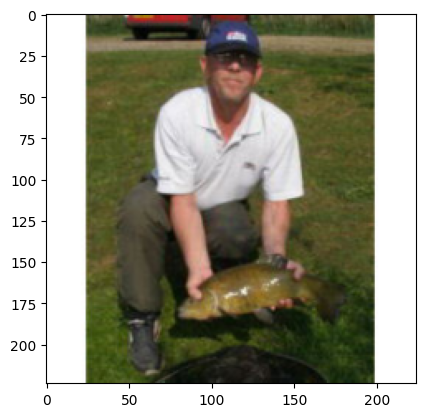

In [10]:
image = ds[0][0]
img = image.detach().cpu().numpy().transpose(1,2,0)
# image = ds[0][0].unsqueeze(dim=0)
labels = torch.tensor(ds[0][1]).unsqueeze(dim=0)
# img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
# img = np.clip(img, 0, 1)
plt.imshow(img)

In [11]:
image = torch.from_numpy(img.transpose(2,0,1)).float().unsqueeze(dim=0)
image.shape

torch.Size([1, 3, 224, 224])

In [12]:
nn = vgg16(weights='IMAGENET1K_V1').to(device)


In [26]:
attack = torchattacks.AutoAttack(nn, norm='Linf', eps=8/255, version='standard', n_classes=1000, seed=None, verbose=False)

In [35]:
adv_images = attack(image, labels)
nn(adv_images).argmax(), nn(image.to(device)).argmax()

(tensor(739, device='cuda:0'), tensor(981, device='cuda:0'))

In [39]:
print(f'{torch.norm(adv_images-image.to(device), p=float('inf')).detach().cpu().numpy()}:.4f')

0.0:.4f


In [15]:
adv_images.shape

torch.Size([1, 3, 224, 224])

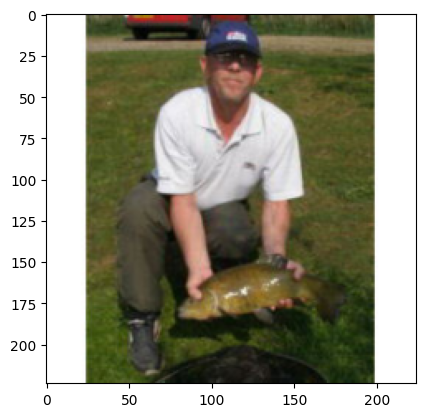

In [16]:
plt.imshow(adv_images[0].detach().cpu().numpy().transpose(1,2,0))

In [18]:
img, adv_images[0]

(array([[[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],
 
        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],
 
        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],
 
        ...,
 
        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],
 
        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],
 
        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]]], dtype=float32),
 tensor([[[1., 1., 1.,  ..., 1., 1., 1.]

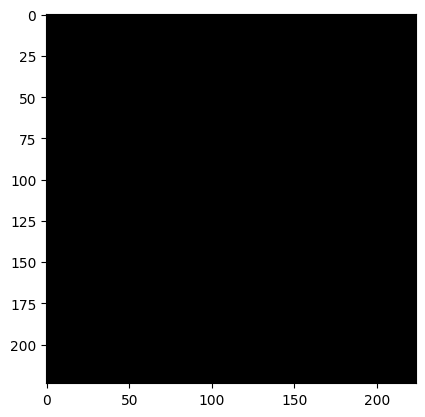

In [20]:
plt.imshow((img*255-adv_images[0].detach().cpu().numpy().transpose(1,2,0)*255)*100000)